# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: [Lectures 2 and 3](https://github.com/UBC-CS/cpsc330-2022W2/tree/main/lectures) 

**Due date: Monday Jan 23, 2023 at 11:59pm**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
sys.path.append("../../lectures/code/.")
from utils import *

## Instructions
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). In particular, **see the note about not pushing downloaded data to your repo**.

You are allowed to work and submit in pairs in this homework assignment. 

## Introducing the data set
 
For this  assignment you'll be looking at Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/) dataset.
The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it to the same directory as this notebook.

## Exercise 1: Exploratory data analysis

#### 1(a) 
rubric={points:2}

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index. **Note:** you may need to change the name of the file if it does not match the download.

In [2]:
spotify_df = pd.read_csv('spotify.csv', index_col=0)
spotify_df.columns
print(f'cols excluding target: {len(spotify_df.columns) - 1}')

cols excluding target: 15


Excluding the target, how many columns (potential features) does the dataset include?

<span style="color:#6495ED">

**The dataset includes 15 columns (potential features) exclusing the target**
</span>

#### 1(b)
rubric={points:2}

Run the following line of code to split the data. How many training and test examples do we have?

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [3]:
df_train, df_test = train_test_split(spotify_df, test_size=0.2, random_state=321)

print(f'num train: {df_train.shape[0]}')
print(f'num test: {df_test.shape[0]}')


num train: 1613
num test: 404


<span style="color:#6495ED">

\# examples in training set: $1613$

\# examples in test set: $404$
</span>

#### 1(c)
rubric={points:3}

- Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
- Which feature has the largest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.

Note that `describe` returns another DataFrame.

In [4]:
train_describe = df_train.describe()
train_describe.loc['range'] = train_describe.loc['max'] - train_describe.loc['min']
print(f'The column with the largest range is: {train_describe.idxmax(axis=1)["range"]}\n'
    + f'with a range of: {train_describe.loc["range"].max()}')
train_describe



The column with the largest range is: duration_ms
with a range of: 988585.0


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1.613000e+03,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185067,0.620076,2.462533e+05,0.681315,0.134317,5.384377,0.191317,-7.095272,0.619343,0.092119,121.310311,3.975201,0.495891,0.512089
std,0.255838,0.161152,8.056740e+04,0.206964,0.274217,3.653722,0.156071,3.678993,0.485699,0.088007,26.431574,0.247829,0.244267,0.500009
min,0.000003,0.148000,1.604200e+04,0.015600,0.000000,0.000000,0.018800,-31.082000,0.000000,0.023100,47.859000,1.000000,0.037300,0.000000
25%,0.010000,0.514000,1.999040e+05,0.564000,0.000000,2.000000,0.092200,-8.388000,0.000000,0.037500,100.221000,4.000000,0.298000,0.000000
50%,0.062600,0.634000,2.298590e+05,0.712000,0.000088,6.000000,0.125000,-6.298000,1.000000,0.055300,121.241000,4.000000,0.492000,1.000000
75%,0.260000,0.739000,2.703330e+05,0.841000,0.055900,9.000000,0.250000,-4.833000,1.000000,0.107000,136.894000,4.000000,0.689000,1.000000
max,0.994000,0.984000,1.004627e+06,0.997000,0.976000,11.000000,0.969000,-0.718000,1.000000,0.622000,219.331000,5.000000,0.974000,1.000000
range,0.993997,0.836000,9.885850e+05,0.981400,0.976000,11.000000,0.950200,30.364000,1.000000,0.598900,171.472000,4.000000,0.936700,1.000000


<span style="color:#6495ED">

The column with the largest range is: 
`duration_ms`


with a range of: $988585.0$
</span>


#### 1(d) 
rubric={points:5}

Let's focus on the following features:

- danceability
- tempo
- energy
- valence

For each of these features (in order), produce a histogram that shows the distribution of the feature values in the training set, **separated for positive and negative examples**. 
By "positive examples" we mean target = 1 (user liked the song, positive sentiment) and by "negative examples" we mean target = 0 (used disliked the song, negative sentiment). As an example, here is what the histogram would look like for a different feature, loudness:



<img src='loudness.png' width="400">

(You don't have to match all the details exactly, such as colour, but your histograms should look something like this, with a reasonable number of bins to see the shape of the distribution.) As shown above, there are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram above shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of the loop, which draws the figure and resets the canvas for your next plot.

Here is some code that separates out the dataset into positive and negative examples, to help you get started:

In [5]:
negative_examples = df_train.query("target == 0")
positive_examples = df_train.query("target == 1")

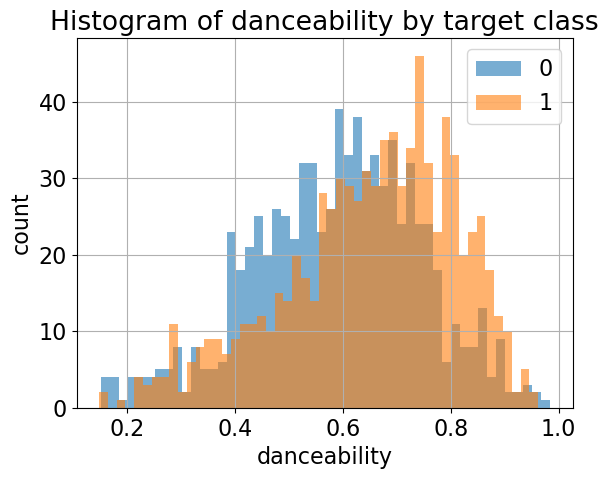

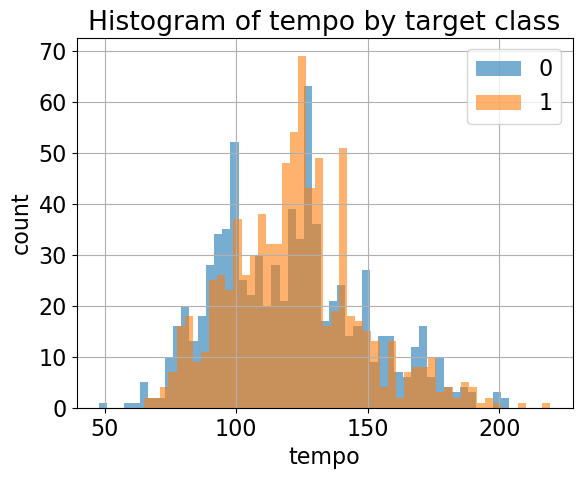

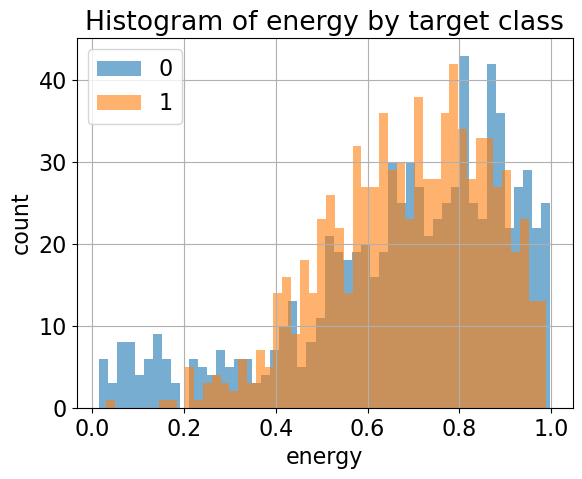

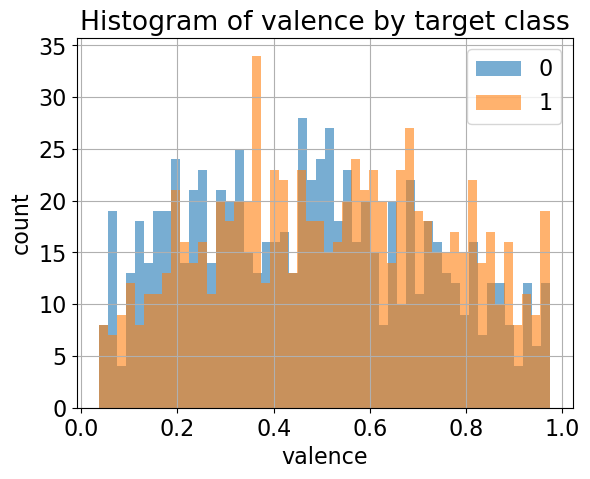

In [6]:
features_1d = ['danceability', 'tempo', 'energy', 'valence']
bins = 50
alpha=0.6
for f in features_1d:
    neg_hist = negative_examples[f].hist(bins=bins, alpha=alpha, label='0')
    pos_hist = positive_examples[f].hist(bins=bins, alpha=alpha, label='1')
    plt.legend()
    plt.xlabel(f)
    plt.ylabel('count')
    plt.title(f'Histogram of {f} by target class')
    plt.show()


#### 1(e)
rubric={points:4}

Let's say you had to make a decision stump (decision tree with depth 1), _by hand_, to predict the target class. Just from looking at the plots above, describe a reasonable split (feature name and threshold) and what class you would predict in the two cases. For example, in the loudness histogram provided earlier on, it seems that very large values of loudness are generally disliked (more blue on the right side of the histogram), so you might answer something like this: "A reasonable split would be to predict 0 if loudness > -5 (and predict 1 otherwise)."

<span style="color:#6495ED">

A reasonable split would be to predict $0$ if $danceability < 0.6$, predict $1$ otherwise.

I chose this feature and threshold because there is a more distinct separation between the positive and negative histograms at around the threshold. For the other 3 features plotted, their distributions overlap well and are therefore quite similar making it difficult to determine a good threshold".
</span>


#### 1(f)
rubric={points:2}

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?



<span style="color:#6495ED">

Yes, a feature with identical histograms for the two target classes indicates that the feature doesn't have a threshold (for decision tree) or other information that distinguishes the two classes and is therefore **not useful** for predicting the target class
</span>

#### 1(g) 
rubric={points:2}

Note that the dataset includes two free text features labeled `song_title` and `artist`:

In [7]:
df_train[["song_title", "artist"]].head()

,song_title,artist
260,WTF (Where They From) [feat. Pharrell Williams],Missy Elliott
1286,"10,000 Reasons (Bless the Lord) [Radio Version]",Matt Redman
1344,American Dream,Chelsea Grin
1197,Feel This Moment,Pitbull
119,Trap Queen,Fetty Wap


- Do you think these features could be useful in predicting whether the user liked the song or not? 
- Would there be any difficulty in using them in your model?   

<span style="color:#6495ED">

The text features could be useful in predicting whether users liked the songs or not. For example, users may prefer songs by specific artists or catchy titles.

However, this data may be difficult to incorporate in a model such as a decision tree because there isn't a threshold we can use on text features that are almost all distinct. 

</span>

## Exercise 2: Using sklearn to build a decision tree classifier

#### 2(a) 
rubric={points:2}

- Create `X_train` and `y_train` and `X_test` and `y_test` from `df_train` and `df_test` above. Skip the `song_title` and `artist` features for now. 
- Fit a `DecisionTreeClassifier` on the train set.

In [8]:
X_train = df_train.drop(columns=["song_title", "artist", "target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["song_title", "artist", "target"])
y_test = df_test["target"]
spotify_model = DecisionTreeClassifier()
spotify_model.fit(X_train, y_train)

DecisionTreeClassifier()

#### 2(b)
rubric={points:2}

Use the `predict` method to predict the class of the tenth example in your `X_train`. Is the prediction correct? That is, does it match with the corresponding class in `y_train`?  

> Hint: you can grab the tenth example with `X_train.iloc[[9]]`.

In [9]:
print(f'prediction: {spotify_model.predict(X_train.iloc[[9]])[0]}\nactual: {y_train.iloc[[9]].values[0]}')

prediction: 1
actual: 1


<span style="color:#6495ED">

The prediction on the 10th example in the `X_train` correctly matches the corresponding class in `y_train`

</span>

#### 2(c) 
rubric={points:2}

Use the `cross_val_score` function on your training set to compute the 10-fold cross-validation accuracy of your tree. 

In [10]:
cv_scores = cross_val_score(spotify_model, X_train, y_train, cv=10)
print('-----Cross-validation Score-----')
print(pd.DataFrame(cv_scores).mean().values[0])
cv_scores

-----Cross-validation Score-----
0.6844873859366613


array([0.7037037 , 0.64814815, 0.62345679, 0.72670807, 0.7515528 ,
       0.61490683, 0.68944099, 0.74534161, 0.65217391, 0.68944099])

In [11]:
pd.DataFrame(cv_scores).describe()

,0
count,10.000000
mean,0.684487
std,0.048686
min,0.614907
25%,0.649155
50%,0.689441
75%,0.720957
max,0.751553


#### 2(d)
rubric={points:2}

The above is useful, but we would like to see the training accuracy as well. 

- Compute the 10-fold cross-validation again but this time using the `cross_validate` function with `return_train_score=True`. 
- Print out both the cross-validation score and the training score.
- Is your cross-validation score exactly the same as what you got in the previous part? Very briefly discuss.

In [12]:
scores = cross_validate(spotify_model, X_train, y_train, cv=10, return_train_score=True)
cv_score_2d = scores['test_score']
train_score_2d = scores['train_score']
print('-----Cross-validation Score-----')
print(pd.DataFrame(cv_score_2d).mean().values[0])
print('-----Training Score-----')
print(pd.DataFrame(train_score_2d).mean().values[0])

-----Cross-validation Score-----
0.6801625642205352
-----Training Score-----
0.9988978817686291


<span style="color:#6495ED">

Cross-validation score is not the same as the one from the previous question.

</span>

#### 2(e)
rubric={points:1}

Do you see a significant difference between the training score and the cross-validation score? Briefly discuss.

<span style="color:#6495ED">

There is a significant difference between the traning score and cross-validation score. This is because the model is trained on the training data so it is a pretty good representation of the underlying patterns and distribution.

However, the split set aside in the training data which is used to assess the model is "unseen" by the model in each fold, therefore this "new" data may have patterns that haven't been seen by the model.

</span>

#### 2(f)
rubric={points:1}

Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your cross validation score?

In [13]:
print('-----Cross-validation Score-----')
print(cv_score_2d)
print('-----Training Score-----')
print(train_score_2d)

-----Cross-validation Score-----
[0.67901235 0.59876543 0.66049383 0.72049689 0.72670807 0.59627329
 0.72049689 0.75776398 0.63975155 0.70186335]
-----Training Score-----
[0.99931082 0.99862164 0.99931082 0.99862259 0.99862259 0.99862259
 0.99862259 0.99931129 0.99931129 0.99862259]


In [14]:
pd.DataFrame(cv_score_2d).describe()

,0
count,10.000000
mean,0.680163
std,0.055375
min,0.596273
25%,0.644937
50%,0.690438
75%,0.720497
max,0.757764


In [15]:
pd.DataFrame(train_score_2d).describe()

,0
count,10.000000
mean,0.998898
std,0.000356
min,0.998622
25%,0.998623
50%,0.998623
75%,0.999311
max,0.999311


<span style="color:#6495ED">

The subscores of the 10-fold cross-validation have a very small variation judging by the small `std`/standard deviation between them showing good precision.

This informs the trustworthiness of the score because it indicates that the model isn't over/underperforming based on luck from bad randomization. 

</span>

## Exercise 3: Hyperparameters 
rubric={points:10}

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

- Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25).
- For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
- Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which.
- Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. From these results, what depth would you pick as the optimal depth? 
- Do you think that the depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

In [16]:
train_acc = []
cv_acc = []
depths = [i for i in range(1, 26)]
for max_depth in depths:
    spotify_model = DecisionTreeClassifier(max_depth=max_depth)
    spotify_model.fit(X_train, y_train)

    scores = cross_validate(spotify_model, X_train, y_train, cv=10, return_train_score=True)
    cv_score_2d = scores['test_score']
    train_score_2d = scores['train_score']
    
    cv_acc.append(pd.DataFrame(cv_score_2d).mean().values[0])
    train_acc.append(pd.DataFrame(train_score_2d).mean().values[0])
max_depths_df = pd.DataFrame(np.transpose(np.asarray([train_acc, cv_acc])), index=depths, columns=['training_acc', 'cross-validation_acc'])
max_depths_df.head()


,training_acc,cross-validation_acc
1,0.645519,0.641063
2,0.717986,0.710505
3,0.731625,0.709888
4,0.764345,0.732781
5,0.792658,0.709900


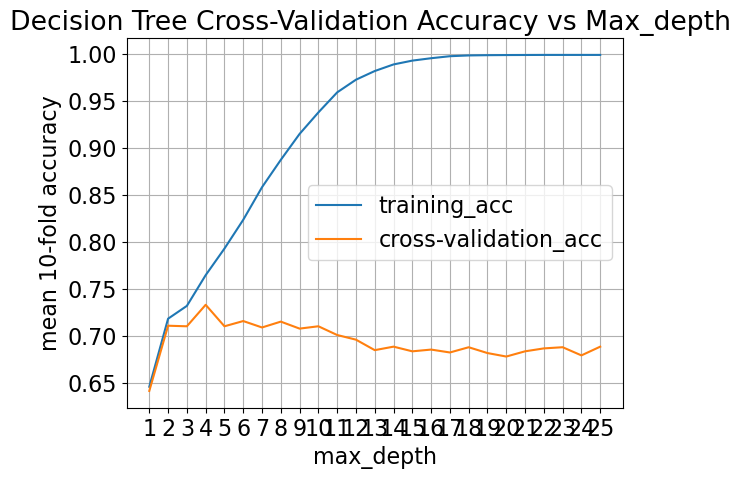

In [17]:
max_depths_df.plot()
plt.xlabel("max_depth")
plt.ylabel("mean 10-fold accuracy")
plt.title("Decision Tree Cross-Validation Accuracy vs Max_depth ")
plt.xticks(depths)
plt.grid()
plt.show()

## Exercise 4: Test set
rubric={points:4}

Remember the test set you created way back at the beginning of this assignment? Let's use it now to see if our cross-validation score from the previous exercise is trustworthy. 

- Select your favorite `max_depth` from the previous part.
- Train a decision tree classifier using that `max_depth` on the _entire training set_.
- Compute and display the test score. 
- How does it compare to the cross-validation score from the previous exercise? Briefly discuss. 

In [18]:
max_depths_df.iloc[[4]]

,training_acc,cross-validation_acc
5,0.792658,0.7099


In [19]:
spotify_model = DecisionTreeClassifier(max_depth=4)
spotify_model.fit(X_train, y_train)
cv_max_depth_4 = max_depths_df.iloc[[4]].values[0]
test_acc = spotify_model.score(X_test, y_test)
validation_acc = cv_max_depth_4[1]
train_acc = cv_max_depth_4[0]
test_err = 1 - test_acc
validation_err = 1 - validation_acc
train_err = 1 - train_acc
print(f'Test set score: {test_acc}\nvalidaton score: {validation_acc}\nTraining score: {train_acc}\n')
print(f'Test set error: {test_err}\nvalidation error: {validation_err}\nTraining error: {train_err}\n')

Test set score: 0.693069306930693
validaton score: 0.7098995475807068
Training score: 0.7926579560405762

Test set error: 0.306930693069307
validation error: 0.29010045241929316
Training error: 0.2073420439594238



<span style="color:#6495ED">
The test score is only slightly lower than the cross-validation score from the previous exercise.

Additionally, the model isn't overfit because the gap between the training and validation error is minimized by choosing a `max_depth=4`.

The model, however, may be underfit since the training and validation error are quite high.

</span>

## Exercise 5: Conceptual questions
rubric={points:3}

Consider the dataset below, which has $6$ examples and $2$ features:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}-1\\-1\\-1\\-1\\+1\\+1\end{bmatrix}.$$

1. Say we fit a decision stump (depth 1 decision tree) and the first split is on the first feature (left column) being less than 5.5. What would we predict in the "true" and "false" cases here?
2. What training accuracy would the above stump get on this data set?
3. Can we obtain 100% accuracy with a single decision stump in this particular example?

<span style="color:#6495ED">

1. For decision stump with first feature less than 5.5

$$\hat{y}=\begin{bmatrix}-1\\-1\\-1\\+1\\+1\\+1\end{bmatrix}$$

2. The training accuracy = 

$$
\begin{aligned}
accuracy&=\frac{\text{correct predictions}}{\text{total examples}}\\
&=\frac{5}{6}=0.83
\end{aligned}
$$

3. In this example, a single decision stump using equality operators such as $<, >, \leq, \geq$ to obtain $100%$ accuracy is impossible. This is because no one split can cleanly separate $y=-1$ and $y=1$ examples for either of the two features


</span>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 